## Initiation

In [2]:
# To manipulate arrays
import numpy as np 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread
from skimage.morphology import dilation, disk
from scipy.ndimage import binary_fill_holes

# Image processing and filters
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import io, filters, data
import napari

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths

# Functions

In [3]:
def detect_files(dir, filetype, string, not_in_string=None, search_subdirs=False):
    file_list = [] # list to store all matching files
    
    # iterate over all files and subdirectories in the given directory
    for item in os.scandir(dir):
        if item.is_file() and item.name.endswith(filetype) and string in item.name:
            if not_in_string is None or not_in_string not in item.name:
                file_list.append(item.path) # add to the list of matching files
        elif item.is_dir() and search_subdirs:
            # if search_subdirs flag is True and the item is a directory, search in it
            file_list.extend(detect_files(item.path, filetype, string, not_in_string, search_subdirs))
    
    return file_list

In [4]:
def my_transpose_list(ar, input_list):
    my_length = len(input_list)  # Should always be 6 = ['fov','f','z','y','x','ch']
    my_none_count = input_list.count('None')  # Get number of 'None' elements in current image
    my_expand_dim_list = tuple(-(np.arange(my_none_count)+1))
    my_count = len(input_list) - my_none_count
    output_list = []
    counter = my_count
    if my_count > 0: 
        for i in np.arange(my_length):
            if input_list[i] == 'None':
                output_list.append(counter)
                counter = counter + 1
            else:
                output_list.append(input_list[i])
    output_ar = np.expand_dims(ar,my_expand_dim_list)
    return np.transpose(output_ar, output_list)
input_list = [0,'None',3,2,'None',1]
my_croparray = my_transpose_list(np.zeros([10,11,12,13]),input_list)
my_croparray.shape

(10, 1, 13, 12, 1, 11)

In [5]:
# Functions for finding nuclei and creating rings around it 
def create_ring(binary_image, width):
    filled_image = dilation(binary_fill_holes(binary_image), footprint=disk(2))
    dilated_image = dilation(filled_image, footprint=disk(width+2))
    ring_image = dilated_image & ~filled_image
    return ring_image

def apply_threshold(image, threshold_factor):
    thresh = threshold_otsu(image)
    bw = closing(image > thresh * threshold_factor, square(3))
    return bw

def remove_border_artifacts(binary_image):
    return clear_border(binary_image)

def create_labeled_image(binary_image):
    return label(binary_image)

def filter_regions_by_area(label_image, min_area):
    filtered_label_image = np.zeros_like(label_image)
    for region in regionprops(label_image):
        if region.area >= min_area:
            filtered_label_image[label_image == region.label] = region.label
    return filtered_label_image

def create_label_overlay(image, label_image):
    return label2rgb(label_image, image=image, bg_label=0)

def create_ring_label_image(label_image, ring_width):
    ring_label_image = np.zeros_like(label_image)
    for label_value in np.unique(label_image):
        if label_value == 0:  # Skip the background label
            continue
        binary_mask = (label_image == label_value)
        ring_image = create_ring(binary_mask, width=ring_width)
        ring_label_image[ring_image] = label_value
    return ring_label_image  

def display_image(image, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def average_intensity_and_center_of_mass(label_image, original_image):
    region_info = {}

    for region in regionprops(label_image):
        label_value = region.label
        mask = (label_image == label_value)
        intensity_values = original_image[mask]
        mean_intensity = np.mean(intensity_values)

        # Calculate center of mass for the region
        center_of_mass = region.centroid

        region_info[label_value] = {
            'average_intensity': mean_intensity,
            'center_of_mass': center_of_mass
        }

    return region_info

In [6]:
def process_frames(img_6D, threshold_factor, min_area, ring_width, output_images=False):
    num_frames = img_6D.shape[1]
    all_regions_data = []
    label_arrays = []
    ring_arrays = []

    for frame in range(num_frames):
        image = img_6D[0, frame, 0, :, :, 0]

        bw = apply_threshold(image, threshold_factor)
        cleared = remove_border_artifacts(bw)
        label_image = create_labeled_image(cleared)
        filtered_label_image = filter_regions_by_area(label_image, min_area)
        image_label_overlay = create_label_overlay(image, filtered_label_image)

        ring_label_image = create_ring_label_image(filtered_label_image, ring_width)
        image_label_overlay_ring = create_label_overlay(image, ring_label_image)

        # if output_images:
        #     display_image(image_label_overlay)
        #     display_image(image_label_overlay_ring)

        region_data = average_intensity_and_center_of_mass(filtered_label_image, image)
        region_data_ring = average_intensity_and_center_of_mass(ring_label_image, image)

        for label_value, data in region_data.items():
            all_regions_data.append({
                'frame': frame,
                'label': label_value,
                'average_intensity': data['average_intensity'],
                'center_of_mass_x': data['center_of_mass'][0],
                'center_of_mass_y': data['center_of_mass'][1],
                'ring': False
            })

        for label_value, data in region_data_ring.items():
            all_regions_data.append({
                'frame': frame,
                'label': label_value,
                'average_intensity': data['average_intensity'],
                'center_of_mass_x': data['center_of_mass'][0],
                'center_of_mass_y': data['center_of_mass'][1],
                'ring': True
            })

        label_arrays.append(filtered_label_image)
        ring_arrays.append(ring_label_image)

    df = pd.DataFrame(all_regions_data)
    return df, np.stack(label_arrays), np.stack(ring_arrays)

In [7]:
def display_with_napari(img_6D, label_arrays, ring_arrays):
    viewer = napari.Viewer()

    # Stack original images into a 3D array (frames, height, width)
    original_images = img_6D[0, :, 0, :, :, 0]

    # Add the original images to the Napari viewer
    viewer.add_image(original_images, name='Original Images', scale=(1, 1, 1))

    # Add the label arrays as a label layer
    viewer.add_labels(label_arrays, name='Label Arrays', scale=(1, 1, 1))

    # Add the ring arrays as a separate label layer
    viewer.add_labels(ring_arrays, name='Ring Arrays', scale=(1, 1, 1))

    # Start the Napari GUI event loop
    napari.run()


In [8]:
def remove_rows_if_less_than(df, column, N):
    """
    Remove rows from the DataFrame where the number of occurrences 
    of the value in the specified column is less than N.

    Parameters:
    - df: pandas DataFrame
    - column: the column to check the value occurrence
    - N: threshold number of occurrences

    Returns:
    - pandas DataFrame after removal of rows
    """
    value_counts = df[column].value_counts()
    to_remove = value_counts[value_counts < N].index
    df_filtered = df[~df[column].isin(to_remove)]
    return df_filtered

# Example usage
# df = pd.read_csv('path_to_your_file.csv')  # Load your DataFrame
# result_df = remove_rows_if_less_than(df, 'your_column_name', N)

# Read in files and process

In [7]:
# Step 1: open all tif files you want to analyze (use a common super directory and all files in subdirectories will be found)
my_vid = detect_files(r'C:\Users\tim_s\OneDrive - Colostate\Stasevich Lab\TokyoTech2022\MintbodyRescueDesigns\H3K27ac-MPNN\Screening-MPNN-Designs\9E2H10mint_design13_TSA_dt5min_dragonfly', '.tif', '9E2H10',not_in_string='_t', search_subdirs=True)
len(my_vid), my_vid

(5,
 ['C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_1\\9E2H10d13_2023-04-25_12.32.37_F0.tif',
  'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_2\\9E2H10d13_2023-04-25_12.32.37_F1.tif',
  'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_3\\9E2H10d13_2023-04-25_12.32.37_F2.tif',
  'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_4\\9E2H10d13_2023-04-2

In [17]:
# Step 2: Read in image
my_n = 1
img_4D =  imread(os.path.join(my_vid[my_n]))
img_4D.shape

(24, 1024, 1024)

In [18]:
# Step 3: Transpose video into crop_array expected 6D format with shape (fov, f, z, y, x, ch)
img_6D = my_transpose_list(img_4D.data,['None',0,'None',1,2,'None']) 
img_6D.shape, img_4D.shape

((1, 24, 1, 1024, 1024, 1), (24, 1024, 1024))

In [19]:
# Step 4: Find nuclei and measure average intensity inside and in surrounding ring:
img_6D_trim = img_6D[:,0:]
df, label_arrays, ring_arrays = process_frames(img_6D, threshold_factor=1.4, min_area=1500, ring_width=5, output_images=True)
df.head()

,frame,label,average_intensity,center_of_mass_x,center_of_mass_y,ring
0,0,303,1570.890915,379.764287,726.425708,False
1,0,919,1590.741506,607.922952,464.410122,False
2,0,303,943.189669,384.172315,721.110453,True
3,0,919,993.996541,611.592508,482.950781,True
4,1,217,1629.848692,380.163204,734.262702,False


In [20]:
# Step 4.5: check data
display_with_napari(img_6D, label_arrays, ring_arrays)

In [40]:
# For TrackPy
import trackpy as tp

# Step 5: Track nuclei using TrackPy

# Modify the DataFrame to match the format expected by trackpy
tracking_df = df.rename(columns={'center_of_mass_x': 'y', 'center_of_mass_y': 'x'})

# Set the search_range parameter for trackpy.link_df()
search_range = 20

# Link the regions across frames using trackpy.link_df()
linked_df = tp.link_df(tracking_df, search_range, memory=2)

# Add a new column to the DataFrame with the particle index assigned by trackpy
df['nuclei'] = linked_df['particle']

df

Frame 23: 6 trajectories present.


,frame,label,average_intensity,center_of_mass_x,center_of_mass_y,ring,nuclei
0,0,261,1055.485597,328.009709,609.969264,False,0
1,0,923,983.568935,469.305178,373.977712,False,1
2,0,2065,965.674170,571.030488,610.253957,False,2
3,0,261,712.114921,324.157121,610.661078,True,3
4,0,923,713.541830,478.186365,374.833927,True,4
...,...,...,...,...,...,...,...
139,23,177,1270.613095,497.136415,353.334176,False,1
140,23,303,1200.876586,505.168397,544.758362,False,6
141,23,14,692.523461,306.860174,619.111295,True,0
142,23,177,712.178530,510.360505,346.511098,True,4


In [167]:
# Export crop array and pytrack dataframe 
root, ext = os.path.splitext(my_vid[my_n])
df.to_csv(root + '_analyzed.csv', index=False)

# Combine data and plot

Step 1: open all csv files

In [9]:
# Step 1: open all tif files you want to analyze (use a common super directory and all files in subdirectories will be found)
my_csvs = detect_files(r'C:\Users\tim_s\OneDrive - Colostate\Stasevich Lab\TokyoTech2022\MintbodyRescueDesigns\H3K27ac-MPNN\Screening-MPNN-Designs\9E2H10mint_design13_TSA_dt5min_dragonfly', '.csv', '9E2H10',not_in_string='puro', search_subdirs=True)
len(my_csvs), my_csvs

(4,
 ['C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_1\\9E2H10d13_2023-04-25_12.32.37_F0_analyzed.csv',
  'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_2\\9E2H10d13_2023-04-25_12.32.37_F1_analyzed.csv',
  'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_Field_4\\9E2H10d13_2023-04-25_12.32.37_F3_analyzed.csv',
  'C:\\Users\\tim_s\\OneDrive - Colostate\\Stasevich Lab\\TokyoTech2022\\MintbodyRescueDesigns\\H3K27ac-MPNN\\Screening-MPNN-Designs\\9E2H10mint_design13_TSA_dt5min_dragonfly\\9E2H10d13_2023-04-25_12.32.37_F

In [10]:
# Read each file into dataframe and then combine into a single dataframe
i=0
all_csvs = []
for file in my_csvs:
    temp = pd.read_csv(file)
    temp = remove_rows_if_less_than(temp,'fov_track_id',15) # Remove nuclei tracks if less than length 5 (or any number)
    temp['file'] = i
    all_csvs.append(temp)
    i=i+1
df_rep0 = pd.concat(all_csvs)

In [11]:
df_rep0.head()

,frame,label,region_id,average_intensity,center_of_mass_x,center_of_mass_y,ring_intensity,track_id,fov_track_id,file,nuclei
0,0,187,f0_r187,3157.114169,561.909055,547.558874,1917.765135,0,fov0-track0,0,NaN
1,1,166,f1_r166,3221.670397,559.603950,546.416728,1935.897701,0,fov0-track0,0,NaN
2,2,158,f2_r158,3201.258343,560.219505,544.174387,1964.876968,0,fov0-track0,0,NaN
3,3,104,f3_r104,3229.012439,557.297687,542.040078,1917.894679,0,fov0-track0,0,NaN
4,4,49,f4_r49,3303.830176,553.614515,541.669941,1874.131707,0,fov0-track0,0,NaN


In [14]:
# Measure quantities of interest
df_rep0['H3K27ac nuc/cyt (a.u.)'] = df_rep0['average_intensity']/df_rep0['ring_intensity']
df_rep0['time (min)'] = df_rep0['frame']*5

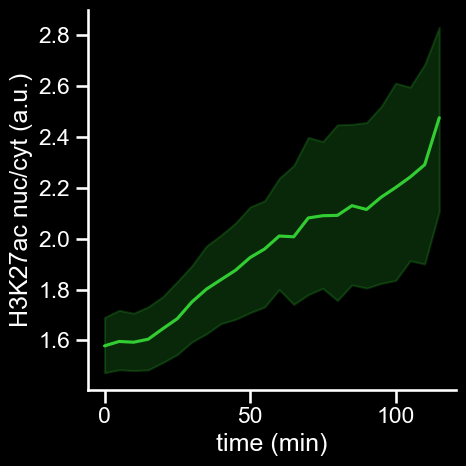

In [21]:
sns.relplot(data=df_rep0, x='time (min)', y='H3K27ac nuc/cyt (a.u.)', color='limegreen', kind='line')

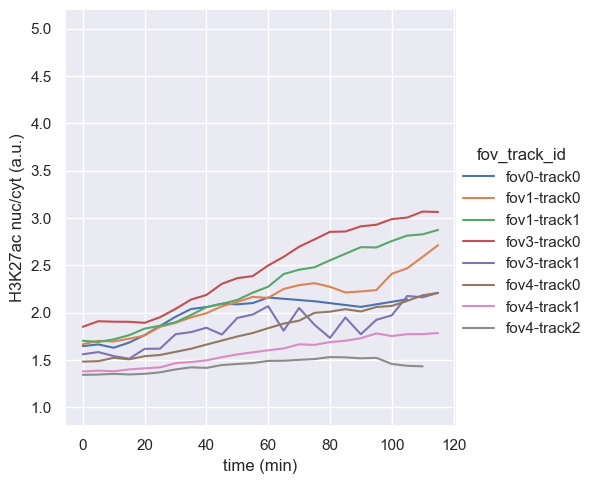

In [26]:
g=sns.relplot(data=df_rep0, x='time (min)', y='H3K27ac nuc/cyt (a.u.)', hue='fov_track_id', kind='line')
g.set(ylim=(0.8,5.2))